# Problem Definition

Predict the price of a diamond, based based on the physical characteristics.

## Dataset

Per diamond in dataset:

* **price** price in US dollars (326--18,823)

* **carat** weight of the diamond (0.2--5.01)

* **cut** quality of the cut (Fair, Good, Very Good, Premium, Ideal)

* **color** diamond colour, from J (worst) to D (best)

* **clarity** a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

* **x** length in mm (0--10.74)

* **y** width in mm (0--58.9)

* **z** depth in mm (0--31.8)

* **depth** total depth percentage (43--79), \begin{equation*}  D_{t,\%} = \frac{z}{mean(x, y)} = \frac{2z}{(x + y)} \end{equation*}

* **table** width of top of diamond relative to widest point (43--95)


In [1]:
# linear algebra
import numpy as np

# data processing, CSV file I/O
import pandas as pd

# data vizualization 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)

# preprocessing of the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# regression moddeling algorithms
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score

# feature importance
from sklearn.inspection import permutation_importance

import time
import os

In [2]:
# data collection
file_path = 'diamonds.csv'
diamond_data = pd.read_csv(file_path, index_col='Unnamed: 0')

# remove id column
diamond_data = diamond_data.rename(columns={'Unnamed: 0': 'Id'})

# 1) Explore Dataset

In [3]:
diamond_data.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [4]:
diamond_data.tail(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
53931,0.71,Premium,E,SI1,60.5,55.0,2756,5.79,5.74,3.49
53932,0.71,Premium,F,SI1,59.8,62.0,2756,5.74,5.73,3.43
53933,0.70,Very Good,E,VS2,60.5,59.0,2757,5.71,5.76,3.47
53934,0.70,Very Good,E,VS2,61.2,59.0,2757,5.69,5.72,3.49
53935,0.72,Premium,D,SI1,62.7,59.0,2757,5.69,5.73,3.58
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
53940,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64


In [5]:
diamond_data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
diamond_data.describe(include='object')

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


### Remark 1:

>  **x y z values are zero**: a diamond with no dimensions

In [7]:
# show diamonds where x, y, or z are zero
diamond_data.loc[(diamond_data['x']==0) | (diamond_data['y']==0) | (diamond_data['z']==0)]

,carat,cut,color,clarity,depth,table,price,x,y,z
2208,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0
2315,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0
4792,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
5472,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
10168,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0
11183,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
11964,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.0
13602,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0
15952,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
24395,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.0


In [8]:
# deleting rows where x, y or z are zero since dataset is big enough
diamond_data = diamond_data[(diamond_data[['x','y','z']] != 0).all(axis=1)]

In [9]:
# Data set dimension and types
print("Shape: ",diamond_data.shape)
diamond_data.info()

Shape:  (53920, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53920 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53920 non-null  float64
 1   cut      53920 non-null  object 
 2   color    53920 non-null  object 
 3   clarity  53920 non-null  object 
 4   depth    53920 non-null  float64
 5   table    53920 non-null  float64
 6   price    53920 non-null  int64  
 7   x        53920 non-null  float64
 8   y        53920 non-null  float64
 9   z        53920 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


## 1.1 Missing Values

In [10]:
# Check if there are missing values in certain columns
cols_with_missing_values = [col for col in diamond_data.columns
                     if diamond_data[col].isnull().any()]
print(cols_with_missing_values)

[]


### Remark 2:
> There are no missing values

## 1.2 Relationships
Explore relationships between features

### 1.2.1 Numerical values

* Carat
* Depth 
* Table
* X,Y and Z

A pairplot shows the pairwise relationships in a dataset. 

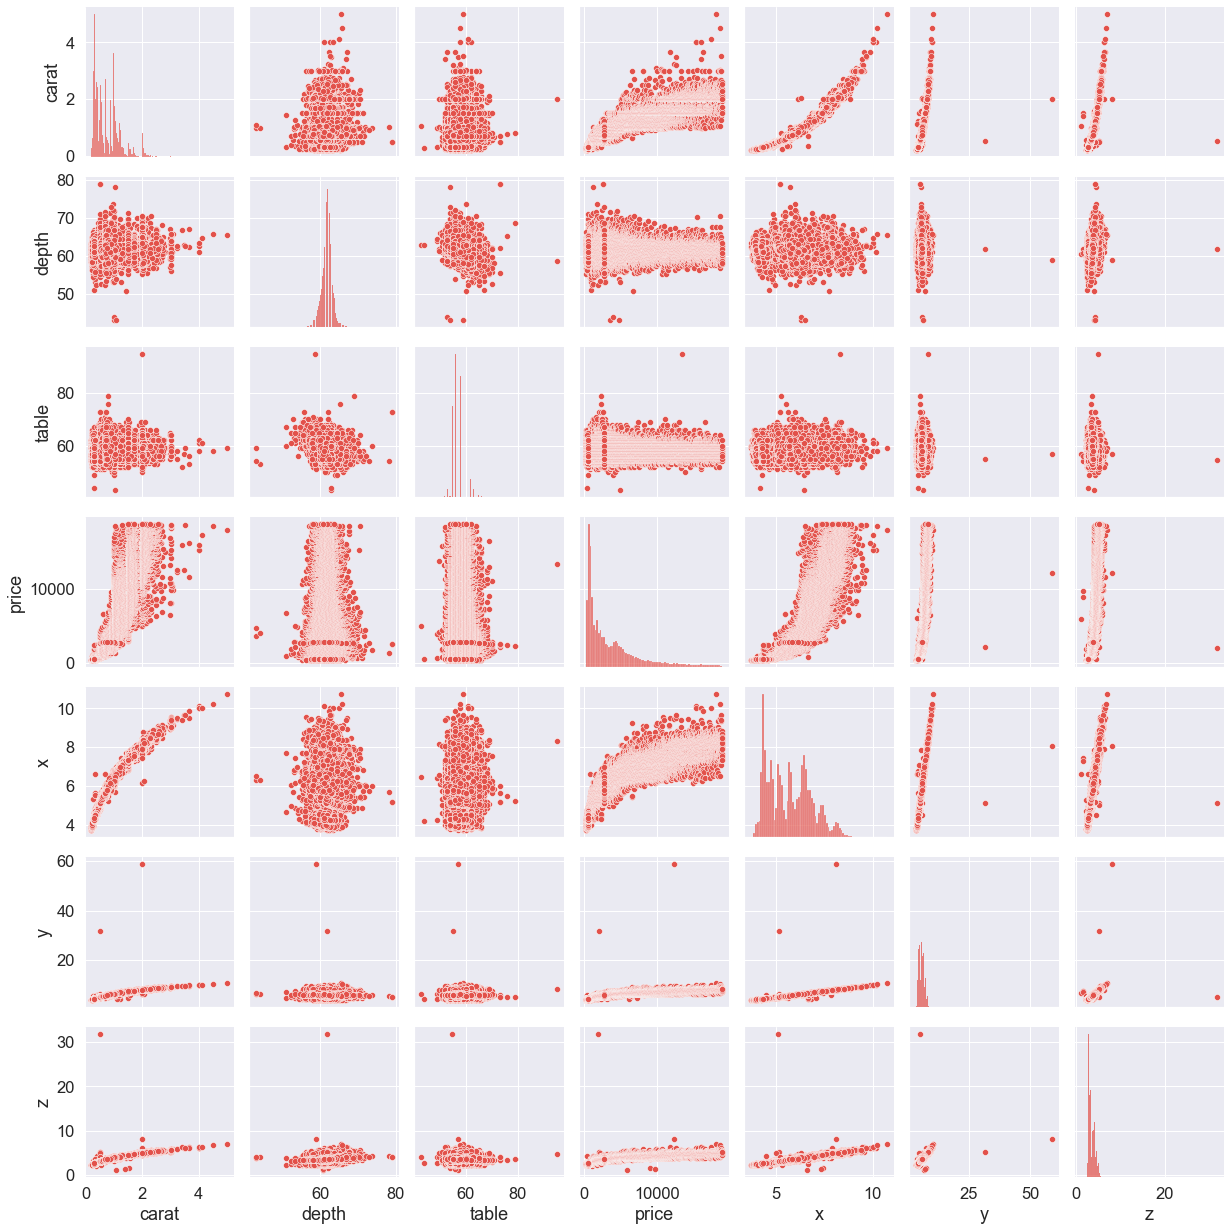

In [11]:
p=sns.pairplot(diamond_data)
p.savefig("diamond_pairplot.png")

### Remark 3:
> * The price increases **exponentional** with the carat/weight and the dimensions
> * Diamonds with the same depth have a variable price
> * Diamonds with the same table have a variable price

### 1.2.2 Categorical values

#### Cut

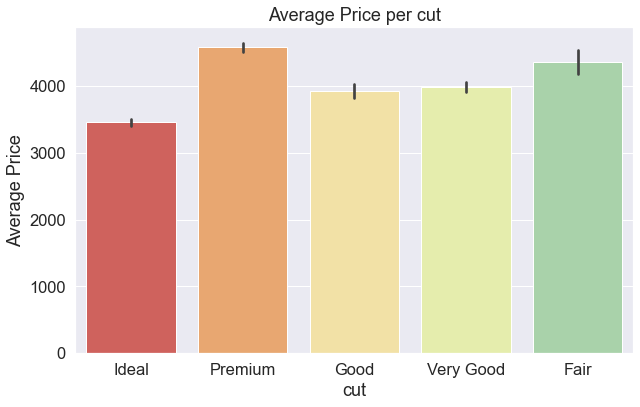

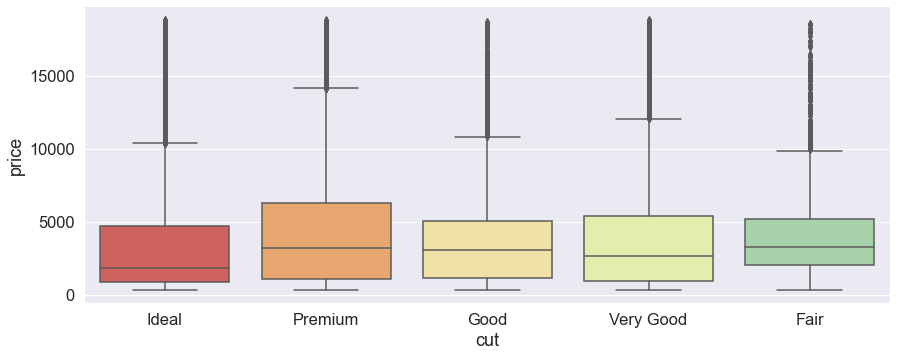

In [12]:
# Average price per cut
plt.figure(figsize=(10,6))
plt.title("Average Price per cut")
sns.barplot(x=diamond_data['cut'], y=diamond_data['price'])
plt.ylabel("Average Price")
plt.savefig("diamond_barplot_cut.png")

# Price per cut
c = sns.catplot(x='cut', y='price' , data=diamond_data , kind='box', aspect=2.5)

c.savefig("diamond_catplot_cut.png")

#### Color

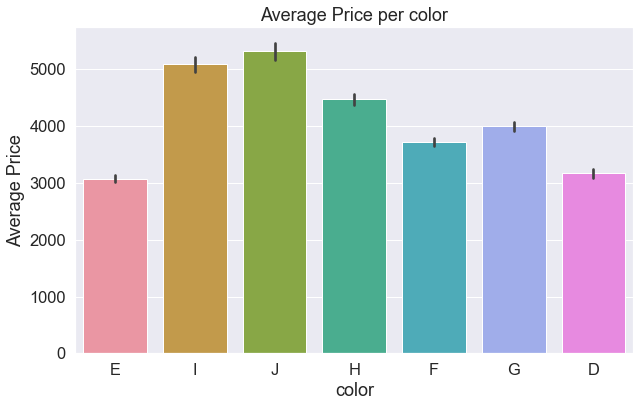

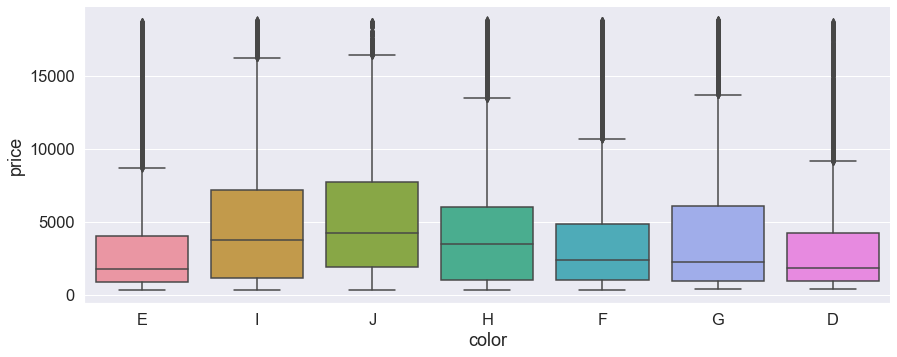

In [13]:
# Average price per color
plt.figure(figsize=(10,6))
plt.title("Average Price per color")
sns.barplot(x=diamond_data['color'], y=diamond_data['price'])
plt.ylabel("Average Price")
plt.savefig("diamond_barplot_color.png")

# Price per color
c = sns.catplot(x='color', y='price' , data=diamond_data , kind='box', aspect=2.5)

c.savefig("diamond_catplot_color.png")

#### Clarity

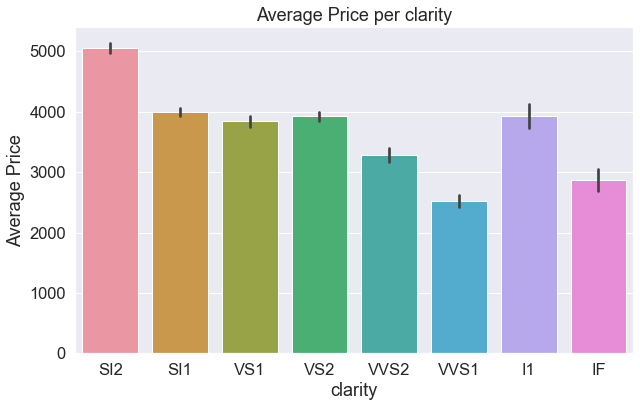

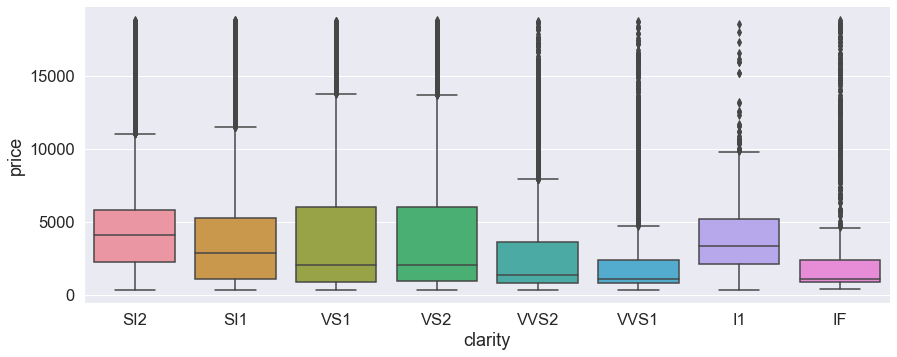

In [14]:
# Average price per clarity
plt.figure(figsize=(10,6))
plt.title('Average Price per clarity')
sns.barplot(x=diamond_data['clarity'], y=diamond_data['price'])
plt.ylabel('Average Price')
plt.savefig("diamond_barplot_clarity.png")

# Price per clarity
c = sns.catplot(x='clarity', y='price' , data=diamond_data , kind='box', aspect=2.5)

c.savefig("diamond_catplot_clarity.png")

In [15]:
diamond_data[(diamond_data['clarity'] == 'IF')].describe()

,carat,depth,table,price,x,y,z
count,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000
mean,0.505123,61.510615,56.507207,2864.839106,4.968402,4.989827,3.061659
std,0.313433,1.041315,1.978291,3920.248499,0.863241,0.864155,0.529660
min,0.230000,52.300000,52.000000,369.000000,3.860000,3.880000,2.390000
25%,0.310000,61.000000,55.000000,895.000000,4.380000,4.390000,2.700000
50%,0.350000,61.700000,56.000000,1080.000000,4.570000,4.590000,2.805000
75%,0.550000,62.100000,58.000000,2388.500000,5.280000,5.317500,3.240000
max,2.290000,65.600000,65.000000,18806.000000,8.490000,8.490000,5.200000


### Remark 4
> * The median value for the price is low compared to the highest price of a certain category, this means that a diamond with a bad color can still have a high price
> * The average prices for better categories (IF) can be lower than worse categories (I1)

## 1.3 Correlation

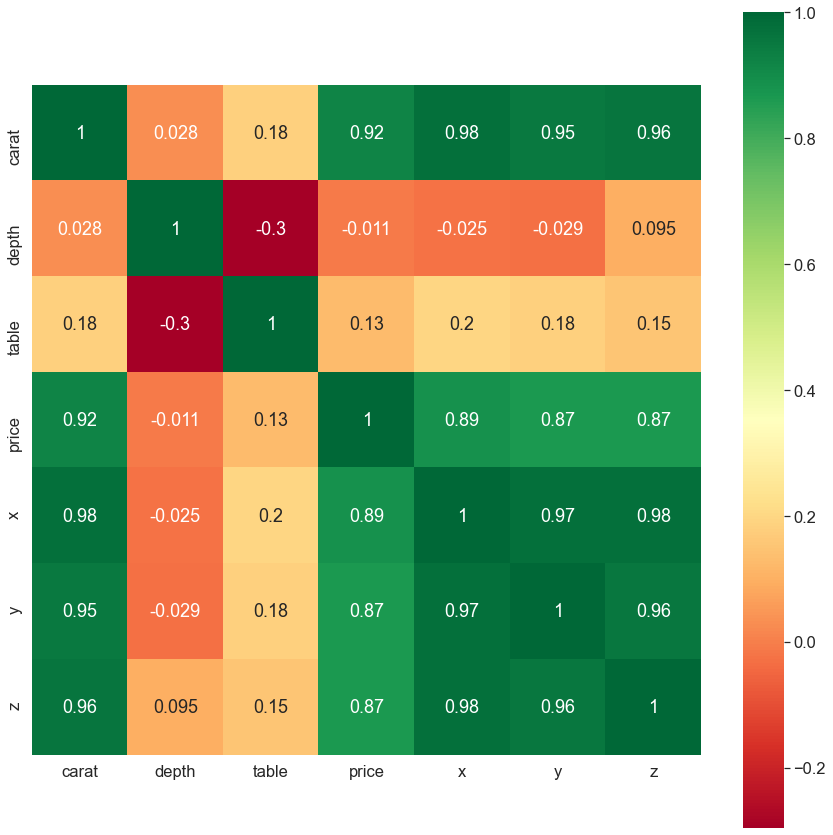

In [16]:
plt.figure(figsize=(15,15)) 
corr = diamond_data.corr()
p=sns.heatmap(corr, annot=True,cmap='RdYlGn',square=True)
plt.savefig('diamond_corr.png')

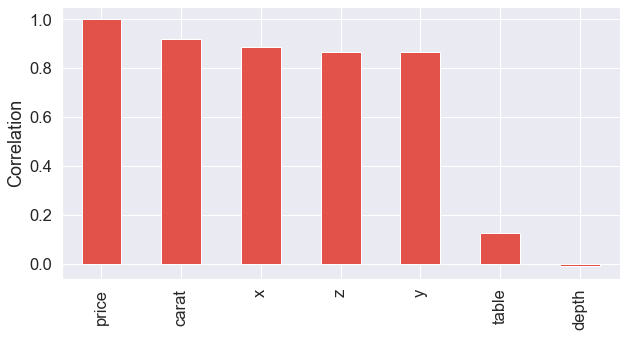

In [17]:
plt.figure(figsize=(10,5))
plt.ylabel("Correlation")
corr['price'].sort_values(ascending=False).plot(kind='bar')
plt.savefig('diamond_corr_2.png')

### Remark 6
> * carat (weight) and dimensions are the most correlated to the price
> * depth and price are negativly correlated: the greater the depth, the lesser the price
> * table is the less correlated to the price

**We can drop the depth feature**

# 2) Data preparation

**Encoding of categorical values:**

A Label Encoder can be used, because the categorical values are ordinal. The values have a certain order:

Fair < Good < Very Good < Premium < Ideal

The data can be encoded on the entire dataset, because the categorical values will stay the same. In the real world no new categorical values will exist.

In [18]:
# select only the columns with a categorical values and a low cardinality (number of possible values that a feature can assume)
categorical_cols = [cat for cat in diamond_data.columns if
                   diamond_data[cat].nunique() < 10 and
                   diamond_data[cat].dtype == "object"]

print("categorical columns: " , categorical_cols)

# map categorical values to ordinal values 
cut_map = {"Fair" : 1, "Good" : 2, "Very Good" : 3, "Premium" : 4, "Ideal" : 5}
color_map = {'E' : 1, 'I' : 2, 'J' : 3, 'H' : 4, 'F' : 5, 'G' : 6, 'D' : 7}
clarity_map = {'SI2' : 1, 'SI1' : 2, 'VS1' : 3, 'VS2' : 4, 'VVS2' : 5, 'VVS1' : 6, 'I1' :7, 'IF' : 8}

diamond_data['cut'] = diamond_data['cut'].map(cut_map)
diamond_data['color'] = diamond_data['color'].map(color_map)
diamond_data['clarity'] = diamond_data['clarity'].map(clarity_map)

# shuffle the data
diamond_data = shuffle(diamond_data)
diamond_data.head()

categorical columns:  ['cut', 'color', 'clarity']


,carat,cut,color,clarity,depth,table,price,x,y,z
51830,0.70,5,5,1,61.4,55.0,2421,5.73,5.77,3.53
20881,1.02,4,5,5,62.9,59.0,9103,6.42,6.37,4.02
23146,1.51,5,4,2,62.3,54.0,11163,7.37,7.33,4.58
23710,0.37,5,2,5,61.9,54.0,632,4.62,4.66,2.87
53823,0.79,4,7,1,61.8,58.0,2735,5.95,5.89,3.66


![](http://)**Split the dataset in train and test dataset**

In [19]:
# select target variable
y = diamond_data.price

# select the predictors
X = diamond_data.drop(['price'], axis=1)

# split dataset in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2,random_state=42)

# create list of estimators
estimators = []

# 3) Train and evaluate the model

- Define a estimator by choosing a learning model
- Fit the data to the estimator
- Evaluate the model by comparing it's price predictions on the test data with the actual price values
- Evaluate model by evaluation metrics
- Refine the model and repeat previous steps

## 3.1 Lineair Regression

In [20]:
# create and fit the model
reg = LinearRegression()

estimators.append(('Linear Regression', reg))

reg.fit(X_train,y_train)

y_pred1 = reg.predict(X_test)

# evaluate the model

acc_lr = reg.score(X_test, y_test)
mae_lr = mean_absolute_error(y_test, y_pred1)
mse_lr = mean_squared_error(y_test, y_pred1)

print('R^2 LinearRegression: ' ,acc_lr)
print('MAE LinearRegression: ', mae_lr)
print('MSE LinearRegression', mse_lr)

R^2 LinearRegression:  0.8698183980097672
MAE LinearRegression:  849.6233306924909
MSE LinearRegression 2051711.8419150775


## 3.2 Random Forest

In [21]:
# create and fit a model
reg = RandomForestRegressor(n_estimators = 100, random_state=0)

estimators.append(('Random Forest', reg))

reg.fit(X_train, y_train)

y_pred2 = reg.predict(X_test)

# evaluate the model
acc_forest = reg.score(X_test, y_test)
mae_forest = mean_absolute_error(y_test, y_pred2)
mse_forest = mean_squared_error(y_test, y_pred2)

print('R^2 RandomForestRegression: ', acc_forest)
print('MAE RandomForestRegression: ', mae_forest)
print('MSE RandomForestRegression: ', mse_forest)

R^2 RandomForestRegression:  0.9803643995663105
MAE RandomForestRegression:  277.78492924372085
MSE RandomForestRegression:  309464.57346512115


## 3.3 Gradient Boosting

In [22]:
# train a model with gradient boosting trees algorithm
# gradient boosting is a method that iteratively adds models to an ensemble (gradient descent on loss function)
params = {
    'n_estimators':500,
    'max_depth': 4,
    'min_samples_split':5,
    'learning_rate':0.05,
    'loss':'ls'}

reg = GradientBoostingRegressor(**params)

estimators.append(('Gradient Boosting', reg))

reg.fit(X_train, y_train)

y_pred3 = reg.predict(X_test)

# evaluate the model
acc_xgbr = reg.score(X_test,y_test)
mae_xgbr = mean_absolute_error(y_test, y_pred3)
mse_xgbr = mean_squared_error(y_test, y_pred3)

print("R^2 GBRegressor: " ,acc_xgbr)
print("MAE GBRegressor: " ,mae_xgbr)
print("MSE GBRegressor:", mse_xgbr)


R^2 GBRegressor:  0.9796874685018874
MAE GBRegressor:  306.33424426895164
MSE GBRegressor: 320133.2659670104


### Training Deviance Gradient Boosting

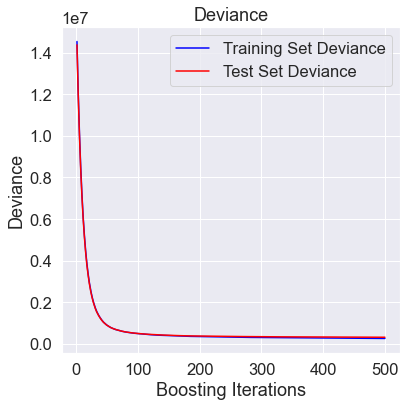

<Figure size 432x288 with 0 Axes>

In [23]:
test_score = np.zeros((params['n_estimators'],),dtype=np.float64)
for i, pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, pred)
    
fig = plt.figure(figsize=(6,6))
plt.subplot(1,1,1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-', label = 'Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label = 'Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()
plt.savefig('diamond_deviance.png')

### Feature Importance Gradient Boosting

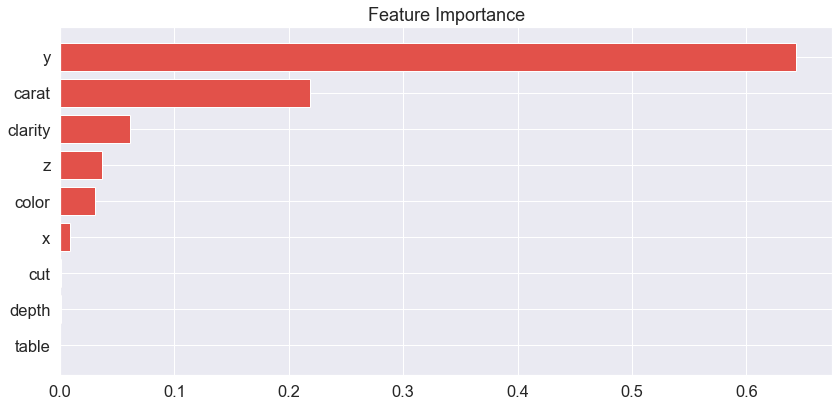

In [24]:
feature_importance = reg.feature_importances_
sorted_importance_index = np.argsort(feature_importance)
pos = np.arange(sorted_importance_index.shape[0]) + .5
fig = plt.figure(figsize=(12,6))
plt.barh(pos, feature_importance[sorted_importance_index], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_importance_index])
plt.title('Feature Importance')
fig.tight_layout()
plt.savefig('diamond_feature_importance.png')
plt.show()

# 4) Conclusion

## Cross validation on all models + vizualization

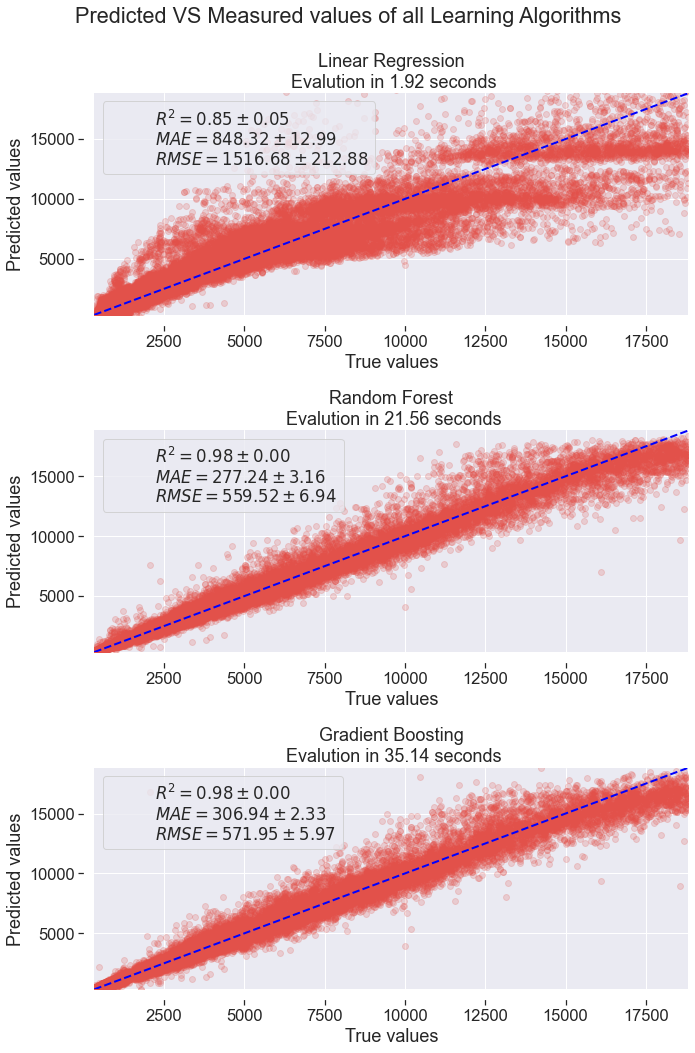

In [25]:
# plot the predicted vs measured values on a scatter plot
# disclaimer: takes a long time to compute 
# if needed adjust n_jobs=-1 (use all avaible CPU's of your computer) to 
# 1 or 2, depending on how many CPU's you want to use
def plot_results(ax, y_test, y_pred, title, scores, elapsed_time):
    
    # plot dashed straight line 
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            '--b', linewidth=2)
    
    # plot true values in function of predicted values
    ax.scatter(y_test, y_pred, alpha=0.2)
    
    # define layout orientation
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward',10))
    ax.spines['bottom'].set_position(('outward',10))
    
    # define range of axis
    ax.set_xlim([y_test.min(), y_test.max()])
    ax.set_ylim([y_test.min(), y_test.max()])
    
    ax.set_xlabel('True values')
    ax.set_ylabel('Predicted values')
    
    # define legend and title
    extra = plt.Rectangle((0,0),0,0,fc='w',fill=False,edgecolor='none',linewidth=0)
    ax.legend([extra],[scores],loc='upper left')
    title = title + '\n Evalution in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

fig, axs = plt.subplots(3,1, figsize=(10,15))
axs = np.ravel(axs)

for ax, (name, estimator) in zip(axs, estimators):
    
    start_time = time.time()
    scores = cross_validate(estimator, X, y, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],
                            n_jobs=-1,verbose=0)
    elapsed_time = time.time() - start_time
    
    y_pred = cross_val_predict(estimator, X, y, n_jobs=-1, verbose=0)
    
    plot_results(ax, y, y_pred, name, 
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$'+ '\n' + r'$RMSE={:.2f} \pm {:.2f}$')
        .format(np.mean(scores['test_r2']),
                np.std(scores['test_r2']),
                -np.mean(scores['test_neg_mean_absolute_error']),
                np.std(scores['test_neg_mean_absolute_error']),
                -np.mean(scores['test_neg_root_mean_squared_error']),
                np.std(scores['test_neg_root_mean_squared_error'])), 
        elapsed_time)

plt.suptitle('Predicted VS Measured values of all Learning Algorithms')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('diamond_scores.png')
plt.show()